In [73]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import wandb

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import models
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

from pythae.models import AE, AEConfig, AutoModel
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
from pythae.data.datasets import DatasetOutput
from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')

## Load medaka data

In [6]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [7]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Flip all left-facing images to the right within the MedakaDataset class

In [8]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [9]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)
        
        return DatasetOutput(data=image) # for pythae

In [10]:
# Load datasets
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)
test_dataset = MedakaDataset(csv_file='test_set_2024-10-03.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [11]:
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

Train length: 889
Validation length: 223


In [12]:
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

torch.Size([3, 64, 64])


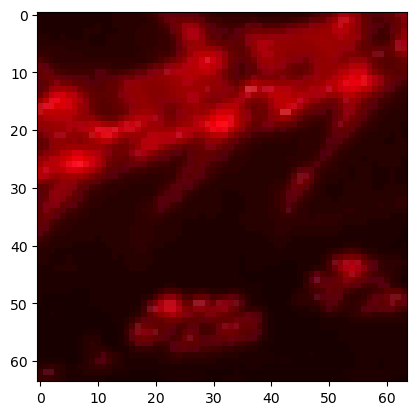

In [52]:
train_example = train_dataset[393]

print(train_example.data.shape)
plt.imshow(train_example.data.permute(1, 2, 0))

Create W&b callback

In [78]:
wandb.login()

wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

In [80]:
callbacks = [] # the TrainingPipeline expects a list of callbacks

wandb_cb = WandbCallback() # Build the callback

os.environ['WANDB_TIMEOUT'] = '120'

## Train convolutional AE pretrained on CELEBA (pythae) (64 x 64)
- AE_training_2024-10-10_15-53-54

In [87]:
model_config = AEConfig(input_dim=(3, 64, 64), latent_dim=64)

model = AE(
    model_config=model_config,
    encoder=Encoder_Conv_AE_CELEBA(model_config), 
    decoder=Decoder_Conv_AE_CELEBA(model_config) 
)

model

AE(
  (decoder): Decoder_Conv_AE_CELEBA(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=65536, bias=True)
      )
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (4): Sequential(
        (0): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1,

In [ ]:
training_config = BaseTrainerConfig(
    output_dir='celeba-convnet64-test',
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    steps_saving=None,
    num_epochs=50)

pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

pipeline(
    train_data=train_dataset,
    eval_data=val_dataset
)

In [54]:
last_training = sorted(os.listdir('celeba-convnet64-test'))[-1]
print(last_training)
trained_model = AutoModel.load_from_folder(os.path.join('celeba-convnet64-test', last_training, 'final_model'))

AE_training_2024-10-10_15-53-54


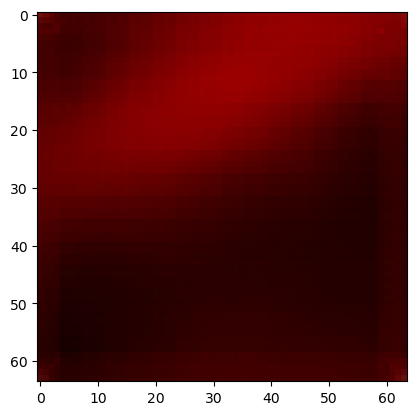

In [55]:
# Test reconstruction of above image on trained model (with cropping images to 64 x 64)
trained_model.eval()

trained_model = trained_model.to(device)
train_example.data = train_example.data.to(device)

# print(train_example.data.unsqueeze(0))
embedding = trained_model.encoder(train_example.data.unsqueeze(0))
out = trained_model.decoder(embedding.embedding)

plt.imshow()

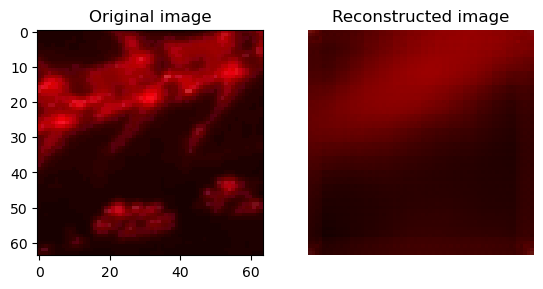

In [60]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example.data.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[0].set_title('Original image')

axs[1].imshow(out.reconstruction.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

## Train ResNet AE pretrained on CELEBA (pythae) (64 x 64)
- AE_training_2024-10-10_16-08-12

In [86]:
model_config = AEConfig(input_dim=(3, 64, 64), latent_dim=64)

model = AE(
    model_config=model_config,
    encoder=Encoder_ResNet_AE_CELEBA(model_config), 
    decoder=Decoder_ResNet_AE_CELEBA(model_config) 
)

model

AE(
  (decoder): Decoder_ResNet_AE_CELEBA(
    (layers): ModuleList(
      (0): Linear(in_features=64, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        (1): Sigmoid()
      )
      (4): Sequential(
        (0): ConvTr

In [62]:
training_config = BaseTrainerConfig(
    output_dir='celeba-resnet64-test',
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    steps_saving=None,
    num_epochs=100)

pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

pipeline(
    train_data=train_dataset,
    eval_data=val_dataset
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created celeba-resnet64-test folder since did not exist.

Created celeba-resnet64-test/AE_training_2024-10-10_16-08-12. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 687.3327
Eval loss: 420.0225
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 252.119
Eval loss: 182.1943
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.8764
Eval loss: 176.3428
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 151.9159
Eval loss: 150.7136
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 146.4741
Eval loss: 134.7852
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8499
Eval loss: 120.6424
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 112.6075
Eval loss: 91.426
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.144
Eval loss: 71.9955
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.6787
Eval loss: 60.0978
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.4141
Eval loss: 58.938
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.4994
Eval loss: 55.9698
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.1253
Eval loss: 56.5492
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.6819
Eval loss: 52.5078
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1119
Eval loss: 51.6051
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.72
Eval loss: 49.9408
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.8829
Eval loss: 48.0034
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.7497
Eval loss: 52.4235
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.416
Eval loss: 57.8501
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.7968
Eval loss: 48.1408
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.6713
Eval loss: 45.5433
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.9858
Eval loss: 40.2687
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.4765
Eval loss: 47.657
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.4422
Eval loss: 38.1615
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.8613
Eval loss: 45.0011
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3255
Eval loss: 42.6814
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.5083
Eval loss: 41.6012
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1472
Eval loss: 36.613
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.896
Eval loss: 42.3944
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.6184
Eval loss: 40.9817
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5371
Eval loss: 43.0128
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.6054
Eval loss: 58.2737
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.6258
Eval loss: 38.0796
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3265
Eval loss: 45.6879
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.5417
Eval loss: 40.7773
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.8028
Eval loss: 39.6942
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.314
Eval loss: 40.6752
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9201
Eval loss: 42.905
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.2518
Eval loss: 38.8499
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7557
Eval loss: 38.0249
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.5452
Eval loss: 43.0008
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9969
Eval loss: 42.4626
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2712
Eval loss: 38.9776
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.0104
Eval loss: 34.5835
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.3779
Eval loss: 63.8404
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.8337
Eval loss: 172.3371
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.0543
Eval loss: 136.3127
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.253
Eval loss: 73.0662
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.7067
Eval loss: 91.9855
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.0412
Eval loss: 55.5233
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.1755
Eval loss: 47.9282
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.8374
Eval loss: 47.721
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.2842
Eval loss: 52.9256
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8436
Eval loss: 39.0636
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2055
Eval loss: 46.1047
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2233
Eval loss: 39.2631
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.0965
Eval loss: 43.1126
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4566
Eval loss: 39.1113
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7401
Eval loss: 43.2533
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.0809
Eval loss: 42.4903
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3929
Eval loss: 37.7875
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.6569
Eval loss: 43.2214
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.2836
Eval loss: 36.9928
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.3242
Eval loss: 44.5584
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4886
Eval loss: 44.6716
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.4435
Eval loss: 45.9164
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.8013
Eval loss: 39.3601
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.0003
Eval loss: 45.5964
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.0834
Eval loss: 38.3238
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8608
Eval loss: 36.7893
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.5973
Eval loss: 37.79
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7038
Eval loss: 31.1024
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1676
Eval loss: 38.5439
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8879
Eval loss: 33.9844
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.7057
Eval loss: 41.8484
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4097
Eval loss: 32.9001
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.6169
Eval loss: 39.474
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6343
Eval loss: 35.7584
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.2531
Eval loss: 36.4715
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4619
Eval loss: 34.5064
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.6954
Eval loss: 32.7429
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6663
Eval loss: 38.0184
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.9069
Eval loss: 42.8925
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.2862
Eval loss: 37.5862
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.1697
Eval loss: 44.8315
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.1057
Eval loss: 43.6008
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.9841
Eval loss: 42.1347
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.4493
Eval loss: 39.0755
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.6938
Eval loss: 40.8423
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.2096
Eval loss: 37.5429
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.444
Eval loss: 36.2608
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.8198
Eval loss: 35.9833
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6179
Eval loss: 34.0442
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.07
Eval loss: 40.8504
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.2125
Eval loss: 41.753
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.3844
Eval loss: 36.209
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.3361
Eval loss: 59.5723
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.453
Eval loss: 46.0871
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4573
Eval loss: 42.268
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7084
Eval loss: 45.1768
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.9991
Eval loss: 46.3284
--------------------------------------------------------------------------
Training ended!
Saved final model in celeba-resnet64-test/AE_training_2024-10-10_16-08-12/final_model


In [63]:
last_training = sorted(os.listdir('celeba-resnet64-test'))[-1]
print(last_training)
trained_model = AutoModel.load_from_folder(os.path.join('celeba-resnet64-test', last_training, 'final_model'))

AE_training_2024-10-10_16-08-12


In [64]:
# Test reconstruction of above image on trained model (with cropping images to 64 x 64)
trained_model.eval()

trained_model = trained_model.to(device)
train_example.data = train_example.data.to(device)

# print(train_example.data.unsqueeze(0))
embedding = trained_model.encoder(train_example.data.unsqueeze(0))
out = trained_model.decoder(embedding.embedding)

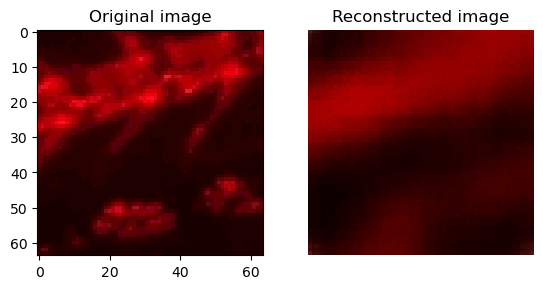

In [67]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example.data.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[0].set_title('Original image')

axs[1].imshow(out.reconstruction.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

## Train ResNet VAE pretrained on CELEBA (pythae) (64 x 64)
- dazzing-forest-2
- AE_training_2024-10-10_16-40-10

In [85]:
model_config = AEConfig(input_dim=(3, 64, 64), latent_dim=64)

model = AE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_CELEBA(model_config), 
    decoder=Decoder_ResNet_AE_CELEBA(model_config) 
)

model

AE(
  (decoder): Decoder_ResNet_AE_CELEBA(
    (layers): ModuleList(
      (0): Linear(in_features=64, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        (1): Sigmoid()
      )
      (4): Sequential(
        (0): ConvTr

In [81]:
training_config = BaseTrainerConfig(
    output_dir='celeba-resnet64-test',
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    steps_saving=None,
    num_epochs=100)


# SetUp W&b callback 
wandb_cb.setup(
    training_config=training_config, # training config
    model_config=model_config, # model config
    project_name="medaka-img", # specify your wandb project
    entity_name="ey267-university-of-cambridge", # specify your wandb entity
)
callbacks.append(wandb_cb) # Add it to the callbacks list

# Call the pipeline
pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

pipeline(
    train_data=train_dataset,
    eval_data=val_dataset,
    callbacks=callbacks
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created celeba-resnet64-test/AE_training_2024-10-10_16-40-10. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 643.6038
Eval loss: 297.7372
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 199.0249
Eval loss: 275.7877
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.0212
Eval loss: 164.4136
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 152.9662
Eval loss: 134.0338
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.1449
Eval loss: 109.4166
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 116.7203
Eval loss: 93.0409
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 93.7089
Eval loss: 86.2933
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.0741
Eval loss: 63.8874
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.5028
Eval loss: 57.1122
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0307
Eval loss: 55.971
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.4766
Eval loss: 52.4242
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.0524
Eval loss: 56.145
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.3575
Eval loss: 53.4519
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.7427
Eval loss: 51.6137
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7794
Eval loss: 48.4875
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1737
Eval loss: 45.3427
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1228
Eval loss: 45.4035
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.426
Eval loss: 55.9751
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1543
Eval loss: 46.7272
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.5764
Eval loss: 44.064
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.0165
Eval loss: 38.9268
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7557
Eval loss: 44.5182
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.3516
Eval loss: 36.861
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.9643
Eval loss: 44.1402
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.6146
Eval loss: 44.9482
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8527
Eval loss: 42.7021
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.8599
Eval loss: 36.889
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4063
Eval loss: 43.6319
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.5155
Eval loss: 41.2948
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.0084
Eval loss: 37.9993
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.0829
Eval loss: 41.6634
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.8495
Eval loss: 37.7003
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.9154
Eval loss: 44.1894
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.2209
Eval loss: 41.0681
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.1387
Eval loss: 39.0631
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3242
Eval loss: 40.3312
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.5919
Eval loss: 42.4807
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.1845
Eval loss: 39.0847
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7374
Eval loss: 37.8076
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.7781
Eval loss: 45.4866
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.228
Eval loss: 43.7542
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.0186
Eval loss: 41.3069
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7469
Eval loss: 36.7791
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.5533
Eval loss: 35.3384
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3126
Eval loss: 44.8857
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.9157
Eval loss: 38.1387
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.6049
Eval loss: 41.7532
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4523
Eval loss: 45.4377
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.1442
Eval loss: 40.3252
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.8821
Eval loss: 36.9996
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.6146
Eval loss: 39.7061
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.5652
Eval loss: 43.3176
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.896
Eval loss: 33.2906
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8697
Eval loss: 41.2767
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.5743
Eval loss: 46.7591
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0155
Eval loss: 41.8945
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.7371
Eval loss: 37.01
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.7944
Eval loss: 40.1458
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1148
Eval loss: 38.1674
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.5747
Eval loss: 33.3749
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.3852
Eval loss: 38.7225
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.496
Eval loss: 32.9831
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9932
Eval loss: 40.2786
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.7284
Eval loss: 34.6542
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4695
Eval loss: 40.3459
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.6275
Eval loss: 35.357
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.2247
Eval loss: 43.3623
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.5266
Eval loss: 34.9107
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.0614
Eval loss: 32.6659
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8792
Eval loss: 33.7567
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1963
Eval loss: 27.5236
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.1589
Eval loss: 34.8599
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.5047
Eval loss: 30.729
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.3365
Eval loss: 39.7732
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.147
Eval loss: 29.8178
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2797
Eval loss: 35.7591
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8434
Eval loss: 33.0086
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.9214
Eval loss: 33.0859
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.4899
Eval loss: 31.3909
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2069
Eval loss: 29.9417
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.7479
Eval loss: 34.0811
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.8264
Eval loss: 37.1641
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.0044
Eval loss: 32.449
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.507
Eval loss: 55.9037
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.8553
Eval loss: 90.298
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 229.662
Eval loss: 375.3116
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 220.9438
Eval loss: 155.9258
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118.292
Eval loss: 99.0605
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.9623
Eval loss: 85.073
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.5165
Eval loss: 88.9686
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.716
Eval loss: 99.7092
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.6721
Eval loss: 79.9872
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.4767
Eval loss: 84.1893
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.8121
Eval loss: 85.3751
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.0799
Eval loss: 89.6327
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.4787
Eval loss: 95.2636
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.1729
Eval loss: 91.2637
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.223
Eval loss: 114.6754
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 117.0109
Eval loss: 119.4724
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/14 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.9709
Eval loss: 122.1412
--------------------------------------------------------------------------
Training ended!
Saved final model in celeba-resnet64-test/AE_training_2024-10-10_16-40-10/final_model


eval/epoch_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▂▃▃▃
train/epoch_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
eval/epoch_loss,122.1412
train/epoch_loss,124.9709
train/global_step,100


In [82]:
trained_model = AutoModel.load_from_folder(os.path.join('celeba-resnet64-test', 'AE_training_2024-10-10_16-40-10', 'final_model'))

In [83]:
# Test reconstruction of above image on trained model (with cropping images to 64 x 64)
trained_model.eval()

trained_model = trained_model.to(device)
train_example.data = train_example.data.to(device)

# print(train_example.data.unsqueeze(0))
embedding = trained_model.encoder(train_example.data.unsqueeze(0))
out = trained_model.decoder(embedding.embedding)

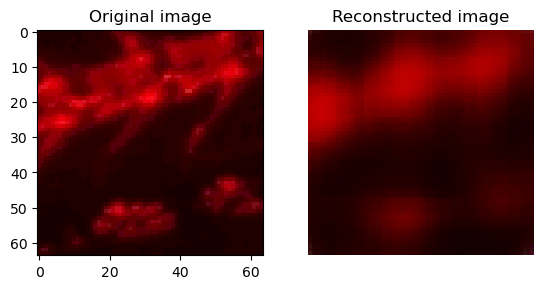

In [84]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example.data.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[0].set_title('Original image')

axs[1].imshow(out.reconstruction.detach().cpu().squeeze(0).permute(1, 2, 0))
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

## 